# Analysis for the floor control detection (FCD) model and competitor models

This notebook includes analyses the predictions of the FCD model and the competitor models discussed in the notebook and show how they are compared over a few measurements. It also includes some stats about the annotated floor properties, and an optimised FCD model for highest accuracy.

In [1]:
import itertools
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyjags
from scipy import optimize as soptimize

import predict_fcd
import utils.annotated_floor
import utils.iteration
import utils.mcmc_plot
import utils.path

In [2]:
%load_ext autoreload

%autoreload 2

plt.style.use('ggplot')
plt.rcParams.update({'axes.titlesize': 'large'})
np.random.seed(1234)

In [3]:
FEATURES_DIR = pathlib.Path('features')
PREDICTIONS_DIR = pathlib.Path('predictions')

ANALYSIS_SAMPLE_RATE = 10
SAMPLE_RATE = {
    'fcd': 50,
    'optimised_fcd': 50,
    'lstm': 20,
    'partial_lstm': 20,
    'vad': 50,
    'random': ANALYSIS_SAMPLE_RATE,
}
MODELS = list(SAMPLE_RATE.keys())
OPTIMISED_FCD_PARAMS = (0.83917969, 0.03746094)  # Can be overriden by lengthy optimisation below

CHAINS = 4
ITERATIONS = 20_000

# Utilities

General utilities.

In [4]:
def array_to_series(x, name, sample_rate):
    '''
    Convert a numpy array to a pandas series
    with time index.
    '''
    x = x[::sample_rate // ANALYSIS_SAMPLE_RATE]
    return pd.Series(
        x,
        index=np.arange(len(x)) / ANALYSIS_SAMPLE_RATE,
        name=name,
    )

In [5]:
def utterances_to_floor(utterances_df):
    '''
    Calculate the floor timeseries from a dataframe
    of utterances (every row has start_time, end_time,
    and participant).
    '''
    return array_to_series(
        list(
            utils.annotated_floor.gen(
                utterances_df,
                sample_rate=ANALYSIS_SAMPLE_RATE,
            )
        ),
        name='floor',
        sample_rate=ANALYSIS_SAMPLE_RATE,
    )

Random model utilities.

In [6]:
def _generate_random_model_intervals(average_floor_duration):
    floor_holder = np.random.randint(2)
    previous_timestamp = 0
    while True:
        samples = np.random.exponential(average_floor_duration, 100)
        timestamps = samples.cumsum() + previous_timestamp
        for timestamp in timestamps:
            yield {
                'start_time': previous_timestamp,
                'end_time': timestamp,
                'participant': floor_holder,
            }
            floor_holder = (floor_holder * -1) + 1
            previous_timestamp = timestamp


def calculate_random_model(average_floor_duration, part_duration):
    '''
    Calculate a random floor array with turns duration distributin
    exponentially with `average_floor_duration` as mean.
    '''
    gen = _generate_random_model_intervals(average_floor_duration)
    gen = itertools.takewhile(lambda i: i['start_time'] < part_duration, gen)
    return list(
        utils.iteration.intervals_to_values_gen(
            gen,
            sample_rate=ANALYSIS_SAMPLE_RATE,
            key='participant',
        )
    )

# Annotated floor stats

In [7]:
def annotated_floor_stats_gen():
    '''
    Calculate basic stats about the annotated floor.
    '''
    for part in utils.path.session_parts_gen(train_set=True, test_set=True):
        utterances_df = pd.read_csv(FEATURES_DIR / 'utterances' / f'{part}.csv')
        floor_intervals = list(utils.annotated_floor.utterances_to_floor_intervals_gen(utterances_df))
        floor = list(
            utils.iteration.intervals_to_values_gen(
                floor_intervals,
                sample_rate=ANALYSIS_SAMPLE_RATE,
                key='participant',
            )
        )
        yield {
            'competition_for_floor': np.isnan(floor).mean(),
            'average_floor_duration': np.mean([i['end_time'] - i['start_time'] for i in floor_intervals])
        }

In [8]:
annotated_floor_stats_df = pd.DataFrame(annotated_floor_stats_gen())
annotated_floor_stats_df.describe()

,competition_for_floor,average_floor_duration
count,30.000000,30.000000
mean,0.162378,3.527355
std,0.062455,1.364506
min,0.069196,1.974816
25%,0.130197,2.379544
50%,0.150684,3.090434
75%,0.179954,4.305084
max,0.406789,7.104639


In [9]:
# Keep the average floor duration for later, for the random model
average_floor_duration = annotated_floor_stats_df['average_floor_duration'].mean()

# Performance measures generators

Generator functions to measure the performance of a model compared to the annotated floor and annotated backhannels.

In [10]:
def accuracy(model, floor):
    '''
    Every 10 seconds, if defined floor (no competition nor silence)
    yields 1 if the model and the floor agrees, 0 otherwise. 10 seconds
    jumps are used to make sure the samples are independent.
    '''
    jump = 10 * ANALYSIS_SAMPLE_RATE
    both = pd.concat([model, floor], axis=1)[::jump].dropna()
    yield from (both.iloc[:, 0] == both.iloc[:, 1]).astype(int)

In [11]:
def backchannels(model, utterances_df):
    '''
    For each backchannel yield 1 if the model report a floor
    for the partner, 0 otherwise.
    '''
    backchannels = utterances_df[utterances_df['backchannel']]
    for _, bc in backchannels.iterrows():
        bc_timestamp = bc['start_time']
        prediction_at_bc = model[bc_timestamp:].values[0]
        if prediction_at_bc:
            yield int(prediction_at_bc != bc['participant'])

In [12]:
def _floor_holder_changes(array):
    array = array[~np.isnan(array)]
    items = utils.iteration.dedup(array)
    return len(list(items)) - 1  # number of changes is number of values minus 1


def stability(model, floor):
    '''
    Ratio of actual floor changes vs. predicted floor changes.
    '''
    annotated_floor_changes = _floor_holder_changes(floor)
    model_floor_changes = _floor_holder_changes(model)
    yield annotated_floor_changes / model_floor_changes

In [13]:
def lag(model, floor):
    '''
    Yield positive lags in seconds.
    '''
    model_change = pd.Series(dict(utils.iteration.dedup(model.dropna().iteritems(), key=lambda x: x[1])))
    floor_change = pd.Series(dict(utils.iteration.dedup(floor.dropna().iteritems(), key=lambda x: x[1])))

    visited_timestamps = set()
    for timestamp, prediction in model_change.iteritems():
        previous_floors = floor_change[:timestamp]
        if not previous_floors.empty:
            current_floor_timestamp = previous_floors.index[-1]
            current_floor_value = previous_floors.values[-1]
            if (current_floor_value == prediction and current_floor_timestamp not in visited_timestamps):
                yield (timestamp - current_floor_timestamp)
            visited_timestamps.add(current_floor_timestamp)

# Optimising FCD parameters for accuracy

In [14]:
def get_negative_accuracy_from_model(params, optimisation_data):

    accuracies = []
    for rms, floor in optimisation_data:
        fcd_gen = predict_fcd.gen_from_rms(rms, *params)
        fcd = array_to_series(list(fcd_gen), name='fcd', sample_rate=SAMPLE_RATE['fcd'])
        accuracies.append(accuracy(fcd, floor))
    
    return -np.mean(accuracies)

In [15]:
optimisation_data = []
for part in utils.path.session_parts_gen(train_set=True, test_set=False):
    utterances_df = pd.read_csv(FEATURES_DIR / 'utterances' / f'{part}.csv')
    floor = utterances_to_floor(utterances_df)
    rms = np.load(FEATURES_DIR / 'FCD' / f'{part}.npy')
    optimisation_data.append((rms, floor))

**Note!** This cell takes a while to run. Feel free to comment it out as the entire notebook can be run without it. The default optimised parameters (declared at the top of the notebook) will be used in that case.

In [16]:
%%time

res = soptimize.minimize(
     get_negative_accuracy_from_model,
     [0.35, 0.1],
     args=(optimisation_data, ),
     method='Nelder-Mead',
     options={'disp': True},
)
OPTIMISED_FCD_PARAMS = res.x
res

Optimization terminated successfully.
         Current function value: -0.884932
         Iterations: 28
         Function evaluations: 63
CPU times: user 11min 24s, sys: 6.04 s, total: 11min 30s
Wall time: 11min 25s


 final_simplex: (array([[0.83917969, 0.03746094],
       [0.83917969, 0.03738281],
       [0.83921387, 0.03741699]]), array([-0.88493247, -0.88493247, -0.88493247]))
           fun: -0.8849324706878398
       message: 'Optimization terminated successfully.'
          nfev: 63
           nit: 28
        status: 0
       success: True
             x: array([0.83917969, 0.03746094])

# Comparing the models performance

In [17]:
def _part_models_stats_gen(part, average_floor_duration):
    utterances_df = pd.read_csv(FEATURES_DIR / 'utterances' / f'{part}.csv')
    floor = utterances_to_floor(utterances_df)
    rms = np.load(FEATURES_DIR / 'FCD' / f'{part}.npy')

    models = {
        'fcd': np.load(PREDICTIONS_DIR / 'FCD' / f'{part}.npy'),
        'optimised_fcd': list(predict_fcd.gen_from_rms(rms, *OPTIMISED_FCD_PARAMS)),
        'lstm': np.load(PREDICTIONS_DIR / 'LSTM' / f'full-{part}.npy'),
        'partial_lstm': np.load(PREDICTIONS_DIR / 'LSTM' / f'partial-{part}.npy'),
        'vad': np.load(PREDICTIONS_DIR / 'VAD' / f'{part}.npy'),
        'random': calculate_random_model(
            average_floor_duration,
            part_duration=floor.index[-1],
        ),
    }

    models_df = pd.concat(
        [array_to_series(x, name=n, sample_rate=SAMPLE_RATE[n]) for n, x in models.items()],
        axis=1,
    )

    measurement_functions_and_args = {
        backchannels: utterances_df,
        **{f: floor for f in [accuracy, stability, lag]},
    }

    for model in models:
        for f, arg in measurement_functions_and_args.items():
            for value in f(models_df[model], arg):
                yield {
                    'part': part,
                    'model': model,
                    'measurement': f.__name__,
                    'value': value,
                }


def models_stats_gen(average_floor_duration):
    '''
    Calculate the performance measure for each model accross the
    test-set.
    '''
    for part in utils.path.session_parts_gen(train_set=False, test_set=True):
        yield from _part_models_stats_gen(part, average_floor_duration)

In [18]:
models_stats_df = pd.DataFrame(models_stats_gen(average_floor_duration))
models_stats_df['model'] = pd.Categorical(
    models_stats_df['model'],
    categories=MODELS,
    ordered=True,
)
for c in ['part', 'measurement']:
    models_stats_df[c] = models_stats_df[c].astype('category')

In [19]:
(
    models_stats_df
    .groupby(['model', 'measurement', 'part'])
    ['value']
    .mean()
    .groupby(['model', 'measurement'])
    .agg(['mean', 'std'])
)

mean       std
model         measurement                     
fcd           accuracy      0.859311  0.027176
              backchannels  0.889487  0.116967
              lag           0.396651  0.032862
              stability     0.856768  0.183371
optimised_fcd accuracy      0.866856  0.057802
              backchannels  0.746855  0.174999
              lag           0.156316  0.029107
              stability     0.479205  0.122705
lstm          accuracy      0.888298  0.035383
              backchannels  0.816202  0.090941
              lag           0.163419  0.089304
              stability     0.290748  0.081568
partial_lstm  accuracy      0.870723  0.032737
              backchannels  0.769757  0.115711
              lag           0.169148  0.120208
              stability     0.242624  0.057588
vad           accuracy      0.747212  0.081713
              backchannels  0.476896  0.219540
              lag           0.487433  0.135832
              stability     0.365151  0.071186
random        accuracy      0.483042  0.082196
              backchannels  0.509509  0.179864
              lag           1.757282  0.403382
              stability     0.961022  0.247827

# Bayesian analysis of differences between the models

Utilities

In [20]:
def gamma_template(mode, sd):
    '''
    Return a string template with shape and rate from mode and sd.
    '''
    rate = f'({mode} + sqrt({mode} ^ 2 + 4 * {sd} ^ 2)) / (2 * {sd} ^ 2)'
    shape = f'1 + {mode} * {rate}'
    return f'{shape}, {rate}'


def beta_template(mode, k):
    '''
    Return a string template with a and b from mode and concentration.
    '''
    a = f'{mode} * ({k} - 2) + 1'
    b = f'(1 - {mode}) * ({k} - 2) + 1'
    return f'{a}, {b}'


def run_model(code, data):
    model = pyjags.Model(code=code, data=data, chains=CHAINS)
    return model.sample(ITERATIONS)


def mode_comparison(trace, models):
    utils.mcmc_plot.param_comparison(
        trace,
        'mode',
        comparison=[MODELS.index(m) for m in models],
        names=models,
    )
    

def compare_two(models, traces, histplot_kwargs=None):
    if histplot_kwargs is None:
        histplot_kwargs = {}

    _, axes = plt.subplots(ncols=len(traces), figsize=(8, 2))
    for ax, (measurement, trace) in zip(axes, traces.items()):
        m1, m2 = [MODELS.index(m) for m in models]
        ax.set(title=measurement)
        ax.axvline(0, linestyle='--', c='grey')
        utils.mcmc_plot.dist(
            trace['mode'][m1].reshape(-1) - trace['mode'][m2].reshape(-1),
            histplot_kwargs=histplot_kwargs,
            ax=ax,
        )

In [21]:
group_by_measurement = models_stats_df.groupby('measurement')

## Accuracy

In [22]:
hierarchical_beta_code = f"""
model {{
    for (m in 1:n_models) {{
        for (p in 1:n_parts) {{
            correct[m, p] ~ dbin(part_mode[m, p], attempts[m, p])
            part_mode[m, p] ~ dbeta({beta_template('mode[m]', 'kappa[m]')})
        }}
        
        mode[m] ~ dbeta({beta_template('MODE', 'KAPPA')})
        kappa[m] = kappa_minus_two[m] + 2
        kappa_minus_two[m] ~ dgamma(2.618, 0.0809)  # Vague mode 20, sd 20
    }}
    
    MODE = 0.5
    KAPPA = 2
}}
"""

In [23]:
_df = group_by_measurement.get_group('accuracy')
accuracy_data = {
    'n_parts': len(_df['part'].unique()),
    'n_models': len(_df['model'].unique()),
    'correct': _df.pivot_table(index='model', columns='part', values='value', aggfunc='sum'),
    'attempts': _df.pivot_table(index='model', columns='part', values='value', aggfunc='count'),
}

In [24]:
accuracy_trace = run_model(code=hierarchical_beta_code, data=accuracy_data)

adapting: iterations 4000 of 4000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 62000 of 80000, elapsed 0:00:10, remaining 0:00:03
sampling: iterations 80000 of 80000, elapsed 0:00:12, remaining 0:00:00


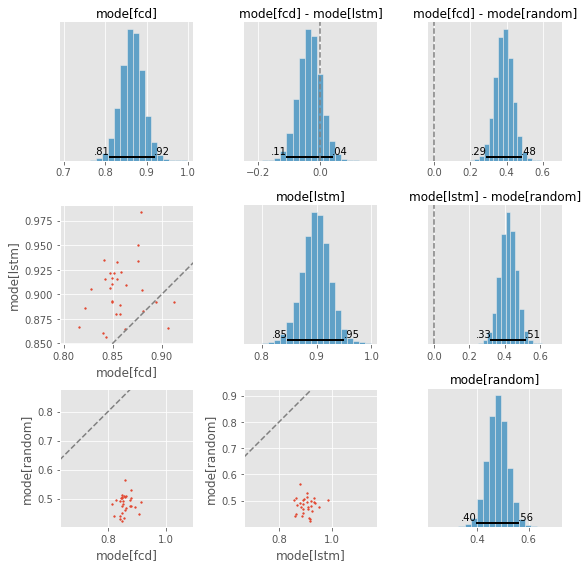

In [25]:
mode_comparison(accuracy_trace, ['fcd', 'lstm', 'random'])

## Backchannels categorisation

In [26]:
_df = group_by_measurement.get_group('backchannels')
bc_data = {
    'n_parts': len(_df['part'].unique()),
    'n_models': len(_df['model'].unique()),
    'correct': _df.pivot_table(index='model', columns='part', values='value', aggfunc='sum'),
    'attempts': _df.pivot_table(index='model', columns='part', values='value', aggfunc='count'),
}

In [27]:
bc_trace = run_model(code=hierarchical_beta_code, data=bc_data)

adapting: iterations 4000 of 4000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 55896 of 80000, elapsed 0:00:09, remaining 0:00:04
sampling: iterations 80000 of 80000, elapsed 0:00:13, remaining 0:00:00


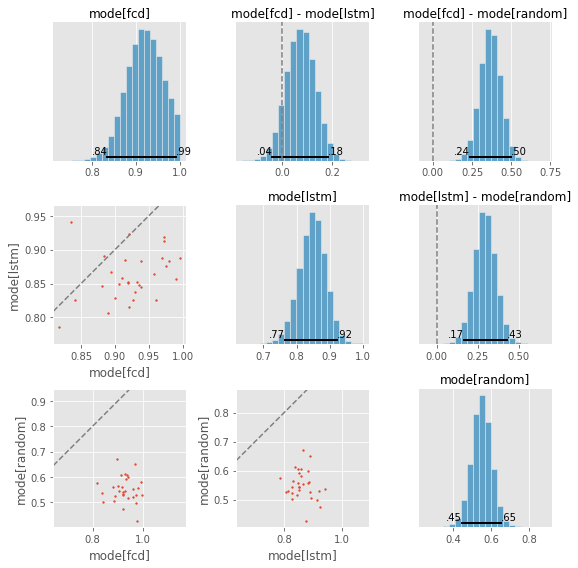

In [28]:
mode_comparison(bc_trace, ['fcd', 'lstm', 'random'])

## Stability

In [29]:
stability_code = f"""
model {{
    for (m in 1:n_models) {{
        for (p in 1:n_parts) {{
            stability[m, p] ~ dgamma({gamma_template('mode[m]', 'sd[m]')})
        }}
        
        mode[m] ~ dgamma({gamma_template('MODE', 'SD')})
        sd[m] ~ dexp(1)
    }}
    
    MODE = 1
    SD = 1
}}
"""

In [30]:
_df = group_by_measurement.get_group('stability')
stability_data = {
    'n_parts': len(_df['part'].unique()),
    'n_models': len(_df['model'].unique()),
    'stability': _df.pivot(index='model', columns='part', values='value'),
}

In [31]:
stability_trace = run_model(code=stability_code, data=stability_data)

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 80000 of 80000, elapsed 0:00:06, remaining 0:00:00
sampling: iterations 80000 of 80000, elapsed 0:00:06, remaining 0:00:00


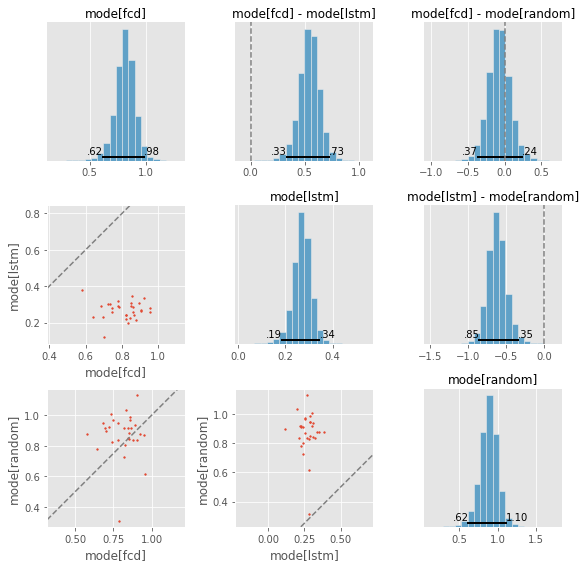

In [32]:
mode_comparison(stability_trace, ['fcd', 'lstm', 'random'])

## Lag

In [33]:
lag_code = f"""
model {{
    for (i in 1:n_lags) {{
        lag[i] ~ dgamma({gamma_template('part_mode[models[i], part[i]]', 'part_sd[models[i], part[i]]')})
    }}
    for (i in 1:n_models) {{
        for (j in 1:n_parts) {{
            part_mode[i, j] ~ dgamma({gamma_template('mode[i]', 'sd[i]')})
            part_sd[i, j] ~ dexp(1)
        }}
        
        mode[i] ~ dgamma({gamma_template('MODE', 'SD')})
        sd[i] ~ dexp(1)
    }}
    
    MODE = 0.5
    SD = 1
}}
"""

In [34]:
_df = group_by_measurement.get_group('stability')
lag_data = {
    'n_parts': len(_df['part'].unique()),
    'n_models': len(_df['model'].unique()),
    'n_lags': len(_df),
    'lag': _df['value'],
    'models': _df['model'].cat.codes + 1,
    'part': _df['part'].cat.codes + 1,
}

In [35]:
lag_trace = run_model(code=lag_code, data=lag_data)

adapting: iterations 4000 of 4000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 36156 of 80000, elapsed 0:00:09, remaining 0:00:11
sampling: iterations 55256 of 80000, elapsed 0:00:14, remaining 0:00:06
sampling: iterations 80000 of 80000, elapsed 0:00:21, remaining 0:00:00
sampling: iterations 80000 of 80000, elapsed 0:00:21, remaining 0:00:00


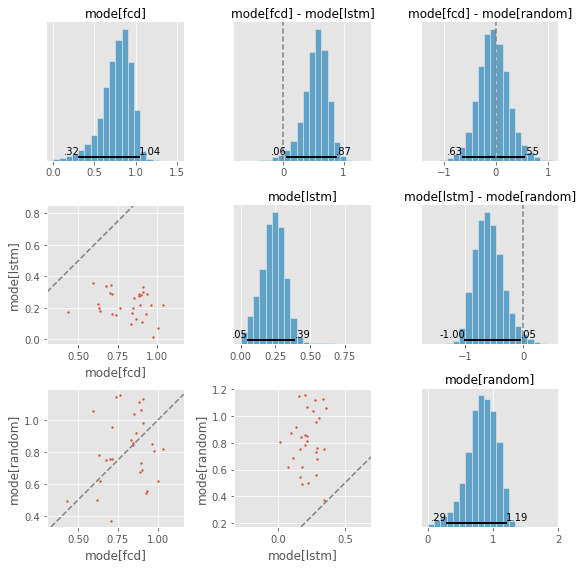

In [36]:
mode_comparison(lag_trace, ['fcd', 'lstm', 'random'])

## FCD with default params vs. optimised FCD

In [37]:
traces = {
    'accuracy': accuracy_trace,
    'backchannels': bc_trace,
    'stability': stability_trace,
    'lag': lag_trace,
}

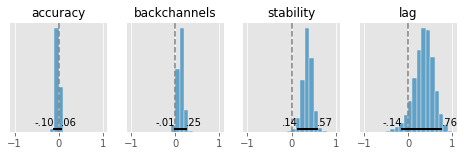

In [38]:
compare_two(['fcd', 'optimised_fcd'], traces, histplot_kwargs={'binrange': (-1, 1)})

## LSTM vs. partial-LSTM

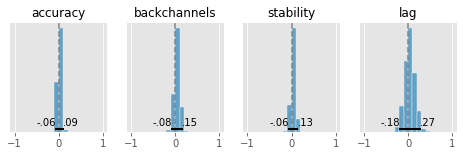

In [39]:
compare_two(['lstm', 'partial_lstm'], traces, histplot_kwargs={'binrange': (-1, 1)})